# Development: Train 3-Category Classifier
Use the latest and greatest model structures, parameters, workflow (ie class weighting, learning fast & slow, etc) to train a 3-category classifier using only the non-road training samples.

This is the latest version as of the start of Phase IV, meant to leverage the previous changes in order to utilize the `fit_generator`.

Date: 2019-02-01  
Author: Peter Kerins  

## Preparation

### Import statements
(may be over-inclusive)

In [1]:
# typical, comprehensive imports
import warnings
warnings.filterwarnings('ignore')
#
import os
import sys
import json
import itertools
import pickle
from pprint import pprint
#
import numpy as np
import shapely
import cartopy
import geojson
import fiona
import gdal
import h5py
get_ipython().magic(u'matplotlib inline')
import matplotlib.pyplot as plt

import pandas as pd

import sklearn
from sklearn.preprocessing import StandardScaler 
import ogr, gdal
from keras.models import load_model
import math
from keras import models
from keras import layers
from keras.layers import Dropout
from keras.utils import to_categorical

import tensorflow as tf

import keras
import keras.backend as K
from keras.models import Model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Input, Add, Lambda
from keras.callbacks import EarlyStopping, ModelCheckpoint, History

import collections
from pprint import pprint

import descarteslabs as dl
print dl.places.find('illinois') ## TEST

ULU_REPO = os.environ["ULU_REPO"]
sys.path.append(ULU_REPO+'/utils')
print sys.path

import util_descartes
import util_ml
import util_rasters
import util_vectors
import util_workflow
import util_chips
import util_training
import util_network
import util_scoring
from batch_generator import BatchGenerator


Using TensorFlow backend.


[{u'name': u'Illinois', u'id': 85688697, u'placetype': u'region', u'bbox': [-91.512974, 36.970298, -87.019935, 42.508302], u'path': u'continent:north-america_country:united-states_region:illinois', u'slug': u'north-america_united-states_illinois'}]
['', '/usr/lib/python2.7', '/usr/lib/python2.7/plat-x86_64-linux-gnu', '/usr/lib/python2.7/lib-tk', '/usr/lib/python2.7/lib-old', '/usr/lib/python2.7/lib-dynload', '/home/Peter.Kerins/.local/lib/python2.7/site-packages', '/usr/local/lib/python2.7/dist-packages', '/usr/lib/python2.7/dist-packages', '/usr/lib/python2.7/dist-packages/PILcompat', '/usr/lib/python2.7/dist-packages/gtk-2.0', '/usr/local/lib/python2.7/dist-packages/IPython/extensions', '/home/Peter.Kerins/.ipython', '/home/Peter.Kerins/UrbanLandUse/utils']


### Set key variables

In [2]:
data_root='/data/phase_iv/'

tile_resolution = 5
tile_size = 256
tile_pad = 32
resolution=tile_resolution  # Lx:15 S2:10

processing_level = None
source = 's2'
#image_suffix = 'E'

s2_bands=['blue','green','red','nir','swir1','swir2','alpha']; s2_suffix='BGRNS1S2A'  # S2, Lx

s1_bands=['vv','vh']; s1_suffix='VVVH'  

resampling='bilinear'
processing = None

label_suffix = 'aue'
label_lot = '0'

# can do much more sophisticated filtering than this, but fine for demonstration
place_images = {}
place_images['sitapur']=['E']


### Specify training data & training parameters

In [3]:
window = 17

# bands stuff outdated! needs to be reconciled with catalog filtering
# will ignore for the moment since this is a bigger fix...
# haven't done any examples yet incorporating additional chips beyond s2
# into construction of a training sample
bands_vir=s2_bands[:-1]
bands_sar=None
bands_ndvi=None
bands_ndbi=None
bands_osm=None

# this can get updated when cloudmasking is added
haze_removal = False

epochs = 500 # this is fine, if irrelevant
batch_size = 128
balancing = None

In [4]:
# needs to be updated completely; bands stuff doesn't make sense right now
stack_label, feature_count = util_workflow.build_stack_label(
        bands_vir=bands_vir,
        bands_sar=bands_sar,
        bands_ndvi=bands_ndvi,
        bands_ndbi=bands_ndbi,
        bands_osm=bands_osm,)
print stack_label, feature_count

vir 6


### Specify data of interest
Load and manipulate the catalog to specify which samples are of interest for this training.

In [7]:
df = util_chips.load_catalog()
print len(df.index)

1898061


In [8]:
mask = pd.Series(data=np.zeros(len(df.index),dtype='uint8'), index=range(len(df)), dtype='uint8')

for place,image_list in place_images.items():
    for image in image_list:
        mask |= (df['city']==place) & (df['image']==image)

# straight away remove road samples
mask &= (df['lulc']!=6)

# filter others according to specifications
mask &= (df['gt_type']==label_suffix)
mask &= (df['gt_lot']==int(label_lot))
mask &= (df['source']==source)
mask &= (df['resolution']==int(resolution))
mask &= (df['resampling']==resampling)
mask &= (df['processing']==str(processing).lower())

print np.sum(mask)

154829


In [9]:
#here for example we will just exclude all roads samples
df = df[mask]
df.reset_index(drop=True,inplace=True)
len(df)

154829

#### Split data (ie catalogs) into training and validation tranches

In [10]:
reload(util_chips)
place_locales = util_chips.apportion_locales(df)
print place_locales
print len(place_locales['sitapur'][0]), len(place_locales['sitapur'][1])

{'sitapur': (array([29,  4, 34, 20,  8, 38,  1, 40, 45, 28, 18, 31, 10, 42, 41,  7, 22,
       37, 12,  5, 16, 26, 33,  0, 39,  3, 27, 13, 36, 14, 43, 44]), array([ 6, 32, 35, 17, 24, 11, 19, 23,  9, 25, 21,  2, 30, 15]))}
32 14


In [11]:
df_t, df_v = util_chips.mask_locales(df, place_locales)
print len(df_t), len(df_v)

106379 48450


## Training

### Build loss function

#### Inspect dataframes for consistency

In [12]:
print util_training.calc_category_counts(df_t,remapping=None), len(df_t)
print util_training.calc_category_counts(df_v,remapping=None), len(df_v)
print
print util_training.calc_category_counts(df,remapping=None), len(df)

{0: 44905, 1: 19118, 2: 13419, 3: 27492, 4: 999, 5: 446} 106379
{0: 25832, 1: 6481, 2: 2214, 3: 13053, 4: 870} 48450

{0: 70737, 1: 25599, 2: 15633, 3: 40545, 4: 1869, 5: 446} 154829


#### Generate class weighting information

In [13]:
category_weights =  util_training.generate_category_weights(df,remapping='standard',log=False,mu=1.0,max_score=None)

In [14]:
print category_weights.items()
weights = list(zip(*category_weights.items())[1])
print weights

[(0, 1.0), (1, 2.76327200281261), (2, 1.2093241926384355)]
[1.0, 2.76327200281261, 1.2093241926384355]


#### Use weights to make weighted categorical crossentropy loss function

In [15]:
loss = util_training.make_loss_function_wcc(weights)

### Build convolutional neural network

#### Name and briefly describe model

In [16]:
model_id = '3cat_Sit_gen-test'
notes = 'new architecture: sitapur E only, 3cat 5m bilinear, no processing'

In [17]:
print("DEFAULT:",K.image_data_format())
K.set_image_data_format('channels_first')
print("UPDATED:",K.image_data_format())

('DEFAULT:', 'channels_last')
('UPDATED:', 'channels_first')


#### Create actual model

In [18]:
#hardcoded params
network=util_network.build_model(util_network.doubleres_block,input_shape=(6,17,17),output_nodes=3)
util_network.compile_network(network, loss, LR=0.001)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 6, 17, 17)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 17, 17)   4832        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 32, 17, 17)   1760        input_1[0][0]                    
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 32, 17, 17)   0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation

---

### Train model fast

#### Create generators to provide training samples

In [19]:
generator_t = BatchGenerator(df_t,remapping='3cat',look_window=window,batch_size=batch_size,one_hot=3)
generator_v = BatchGenerator(df_v,remapping='3cat',look_window=window,batch_size=batch_size,one_hot=3)

#### Create callback functions for training

In [20]:
weights_label='weights_fast'
callbacks, weights_path = util_training.create_callbacks(data_root, model_id, weights_label=weights_label, patience=2)

#### Conduct training using `fit_generator` and visualize progress

Epoch 1/500
832/832 [==============================] - 184s 221ms/step - loss: 1.0075 - acc: 0.6980 - val_loss: 1.0273 - val_acc: 0.7244
Epoch 2/500
832/832 [==============================] - 151s 181ms/step - loss: 0.7353 - acc: 0.7926 - val_loss: 1.0948 - val_acc: 0.7417


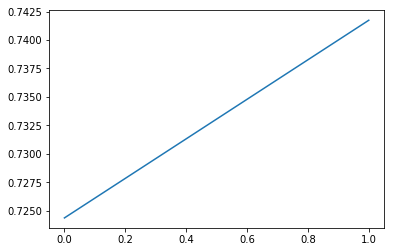

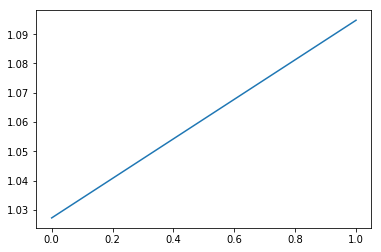

In [21]:
# train fast
#history_fast = network.fit(X_train, Y_t_cat, batch_size=batch_size, epochs=epochs, validation_data=(X_valid, Y_v_cat), shuffle=True,callbacks=callbacks)
#docs: fit_generator(generator, steps_per_epoch=None, epochs=1, verbose=1, callbacks=None, validation_data=None, validation_steps=None,
                    #class_weight=None, max_queue_size=10, workers=1, use_multiprocessing=False, shuffle=True, initial_epoch=0)
history_fast = network.fit_generator(generator_t, epochs=epochs, callbacks=callbacks, steps_per_epoch=generator_t.steps,
                                    validation_data=generator_v, validation_steps=generator_v.steps,
                                    shuffle=True,use_multiprocessing=True,max_queue_size=40,workers=64,)

plt.plot(history_fast.history['val_acc'])
plt.show()
plt.plot(history_fast.history['val_loss'])
plt.show()

---

### Rebuild model and train slow

In [22]:
#hardcoded params
network=util_network.build_model(util_network.doubleres_block,input_shape=(6,17,17),output_nodes=3)
# load weights from fast learning
network.load_weights(weights_path)

util_network.compile_network(network, loss, LR=0.0001)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 6, 17, 17)    0                                            
__________________________________________________________________________________________________
conv2d_11 (Conv2D)              (None, 32, 17, 17)   4832        input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_13 (Conv2D)              (None, 32, 17, 17)   1760        input_2[0][0]                    
__________________________________________________________________________________________________
activation_11 (Activation)      (None, 32, 17, 17)   0           conv2d_11[0][0]                  
__________________________________________________________________________________________________
activation

#### Create generators to provide training samples

In [23]:
generator_t.reset()
generator_v.reset()

#### Create callback functions for training

In [24]:
weights_label='weights_slow'
callbacks, weights_path = util_training.create_callbacks(data_root, model_id, weights_label=weights_label, patience=5)

#### Conduct training using `fit_generator` and visualize progress

Epoch 1/500
832/832 [==============================] - 143s 171ms/step - loss: 0.7394 - acc: 0.7919 - val_loss: 1.0262 - val_acc: 0.6816
Epoch 2/500
832/832 [==============================] - 116s 140ms/step - loss: 0.6814 - acc: 0.8068 - val_loss: 1.0355 - val_acc: 0.7303
Epoch 3/500
832/832 [==============================] - 122s 146ms/step - loss: 0.6356 - acc: 0.8205 - val_loss: 1.0646 - val_acc: 0.7375
Epoch 4/500
832/832 [==============================] - 120s 144ms/step - loss: 0.5926 - acc: 0.8325 - val_loss: 1.1185 - val_acc: 0.7096
Epoch 5/500
832/832 [==============================] - 116s 139ms/step - loss: 0.5598 - acc: 0.8416 - val_loss: 1.1180 - val_acc: 0.7207
Epoch 6/500
832/832 [==============================] - 114s 137ms/step - loss: 0.5259 - acc: 0.8525 - val_loss: 1.1966 - val_acc: 0.7225


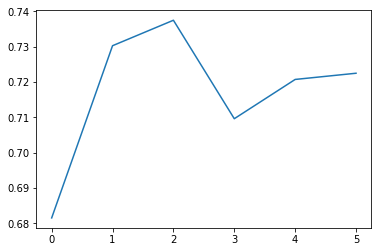

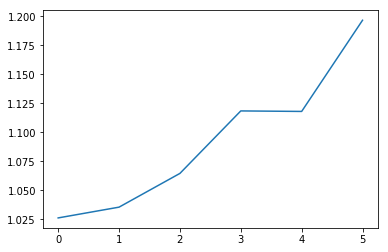

In [25]:
history_slow = network.fit_generator(generator_t, epochs=epochs, callbacks=callbacks, steps_per_epoch=generator_t.steps,
                                    validation_data=generator_v, validation_steps=generator_v.steps,
                                    shuffle=True,use_multiprocessing=True,max_queue_size=40,workers=64,)

plt.plot(history_slow.history['val_acc'])
plt.show()
plt.plot(history_slow.history['val_loss'])
plt.show()

---

## Scoring

### Apply model to training and validation data

In [27]:
generator_t.reset()
#predict_generator(generator, steps=None, max_queue_size=10, workers=1, use_multiprocessing=False, verbose=0)
predictions_t = network.predict_generator(generator_t, steps=generator_t.steps, verbose=1,
                  use_multiprocessing=True, max_queue_size=40, workers=64,)
print predictions_t.shape

generator_v.reset()
#predict_generator(generator, steps=None, max_queue_size=10, workers=1, use_multiprocessing=False, verbose=0)
predictions_v = network.predict_generator(generator_v, steps=generator_v.steps, verbose=1,
                  use_multiprocessing=True, max_queue_size=40, workers=64,)
print predictions_v.shape

832/832 [==============================] - 63s 76ms/step
(106379, 3)
379/379 [==============================] - 48s 128ms/step
(48450, 3)


In [28]:
Yhat_t = predictions_t.argmax(axis=-1)
print Yhat_t.shape
Yhat_v = predictions_v.argmax(axis=-1)
print Yhat_v.shape

(106379,)
(48450,)


### Extract corresponding _actual_ ground-truth values directly from catalog

In [29]:
Y_t = generator_t.get_label_series().values
print Y_t.shape
Y_v = generator_v.get_label_series().values
print Y_v.shape

(106379,)
(48450,)


### Generate typical scoring information

In [30]:
print "evaluate training"
# hardcoded categories
categories=[0,1,2]
train_confusion = util_scoring.calc_confusion(Yhat_t,Y_t,categories)
train_recalls, train_precisions, train_accuracy = util_scoring.calc_confusion_details(train_confusion)

# Calculate f-score
beta = 2
train_f_score = (beta**2 + 1) * train_precisions * train_recalls / ( (beta**2 * train_precisions) + train_recalls )
train_f_score_open = train_f_score[0] 
train_f_score_nonres = train_f_score[1]  
train_f_score_res = train_f_score[2]  
train_f_score_roads = None#train_f_score[3]  
train_f_score_average = np.mean(train_f_score)

evaluate training
0 44905
1 19118
2 42356
[[38228  3198  3479]
 [  845 16406  1867]
 [ 1596  2103 38657]]
106379 93291 0.876968198610628


In [31]:
print "evaluate validation"
valid_confusion = util_scoring.calc_confusion(Yhat_v,Y_v,categories)
valid_recalls, valid_precisions, valid_accuracy = util_scoring.calc_confusion_details(valid_confusion)

# Calculate f-score
valid_f_score = (beta**2 + 1) * valid_precisions * valid_recalls / ( (beta**2 * valid_precisions) + valid_recalls )
valid_f_score_open = valid_f_score[0] 
valid_f_score_nonres = valid_f_score[1] 
valid_f_score_res = valid_f_score[2] 
valid_f_score_roads = None# valid_f_score[3] 
valid_f_score_average = np.mean(valid_f_score)

evaluate validation
0 25832
1 6481
2 16137
[[19369  4549  1914]
 [ 1904  3303  1274]
 [ 1920  1885 12332]]
48450 35004 0.7224767801857586


In [32]:
# expanding lists to match expected model_record stuff
train_recalls_expanded = [train_recalls[0],train_recalls[1],train_recalls[2],None]
valid_recalls_expanded = [valid_recalls[0],valid_recalls[1],valid_recalls[2],None]
train_precisions_expanded = [train_precisions[0],train_precisions[1],train_precisions[2],None]
valid_precisions_expanded = [valid_precisions[0],valid_precisions[1],valid_precisions[2],None]

### Record experiment configuration and results

In [33]:
reload(util_scoring)
#scaler_filename = data_root+'models/'+model_id+'_scaler.pkl'
#model_filename  = data_root+'models/'+model_id+'_SVM.pkl'
place_locales_filename = data_root+'models/'+model_id+'_place_locales.pkl'
category_weights_filename = data_root+'models/'+model_id+'_category_weights.pkl'
network_filename = data_root+'models/'+model_id+'.hd5'

if os.path.exists(network_filename):
    print 'Aborting all pickle operations: file already exists at specified path ('+network_filename+')'
elif os.path.exists(category_weights_filename):
    print 'Aborting all pickle operations: file already exists at specified path ('+category_weights_filename+')'
else:
    print network_filename
    pickle.dump(place_locales, open(place_locales_filename, 'wb'))
    pickle.dump(category_weights, open(category_weights_filename, 'wb'))
    network.save(network_filename)
    # tracking only occurs if all saves are successful
    util_scoring.record_model_creation(
        model_id, notes, place_images, label_suffix+label_lot, resolution, stack_label, feature_count, 
        window, generator_t.remapping, balancing, 
        network.get_config(), epochs, batch_size,
        train_confusion, train_recalls_expanded, train_precisions_expanded, train_accuracy,
        train_f_score_open, train_f_score_nonres, train_f_score_res, train_f_score_roads, train_f_score_average,
        valid_confusion, valid_recalls_expanded, valid_precisions_expanded, valid_accuracy,
        valid_f_score_open, valid_f_score_nonres, valid_f_score_res, valid_f_score_roads, valid_f_score_average,)

/data/phase_iv/models/3cat_Sit_gen-test.hd5
model scorecard updated


---